In [126]:
import pandas as pd
import numpy  as np
import seaborn as sns
import matplotlib.pyplot as plt

In [139]:
train = pd.read_csv("data/train.csv")
test  = pd.read_csv("data/test.csv")
df    = pd.concat([train,test],axis=0, sort=False)
df.head()

,id,playerID,yearID,stint,teamID,lgID,W,L,G,GS,...,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP,salary_next_year
0,0,nelsoge01,1986,1,CHA,AL,6,6,54,1,...,3.0,3.0,0.0,488.0,26.0,52,NaN,NaN,NaN,365000.0
1,1,moyerja01,1997,1,SEA,AL,17,5,30,30,...,3.0,7.0,0.0,787.0,0.0,82,NaN,NaN,NaN,2000000.0
2,2,thompbr01,2008,1,SLN,NL,6,3,26,6,...,2.0,3.0,0.0,273.0,10.0,38,NaN,NaN,NaN,650000.0
3,3,powerte01,1986,1,CIN,NL,10,6,56,10,...,5.0,1.0,1.0,537.0,30.0,59,NaN,NaN,NaN,500000.0
4,4,osunaan01,2003,1,NYA,AL,2,5,48,0,...,3.0,2.0,0.0,232.0,16.0,22,NaN,NaN,NaN,750000.0


In [140]:
# 檢查 DataFrame 空缺值的狀態
def na_check(df_data):
    data_na = (df_data.isnull().sum() / len(df_data)) * 100
    data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)
    missing_data = pd.DataFrame({'Missing Ratio' :data_na})
    display(missing_data.head(10))
na_check(df)

,Missing Ratio
GIDP,100.000000
SF,100.000000
SH,100.000000
BAOpp,39.050453
salary_next_year,15.000676
BK,0.013526
HBP,0.013526
WP,0.013526
IBB,0.013526


In [141]:
# 去除大量遺失數據
df = df.drop(['GIDP','SF','SH'],axis=1)
df.shape

(7393, 29)

In [142]:
mask = (df['BK'].isnull() | df['HBP'].isnull() | df['WP'].isnull() | df['IBB'].isnull())
print("極少量遺失數據數量=",mask.sum())
df.iloc[mask.values]
print("推測因沒上場幾次，所以應該都為零")
df.iloc[mask.values] = df.iloc[mask.values].fillna(0)
na_check(df)

極少量遺失數據數量= 1
推測因沒上場幾次，所以應該都為零


,Missing Ratio
BAOpp,39.050453
salary_next_year,14.987150


In [231]:
# fill BAOpp
from xgboost import XGBRegressor
from sklearn import metrics  

other_params = {'learning_rate': 0.1, 'n_estimators': 500, 'max_depth': 5, 'min_child_weight': 1, 'seed': 0,
'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1}
model = XGBRegressor(**other_params)

data_x = df.iloc[:,6:28]
data_y = data_x['BAOpp']
data_x.drop('BAOpp', axis=1)

train_x = data_x[data_y.notna()]
test_x  = data_x[data_y.isna()]
train_y = data_y[data_y.notna()]

model.fit(train_x, train_y)
predict_y= model.predict(train_x)

[23:48:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [233]:
score   = metrics.r2_score(train_y, predict_y)
print(score)

0.9999732792667049


In [228]:
print(np.max(train_y),"  ," , np.min(train_y))
print(np.max(result_y),"  ," , np.min(result_y))
test_x

0.66   , 0.0
0.6590775   , -0.0023226142


,W,L,G,GS,CG,SHO,SV,IPouts,H,ER,...,SO,BAOpp,ERA,IBB,WP,HBP,BK,BFP,GF,R
2,6,3,26,6,0,0,0,194,72,37,...,32,NaN,5.15,1.0,2.0,3.0,0.0,273.0,10.0,38
8,14,16,33,33,0,0,0,583,221,130,...,96,NaN,6.02,2.0,2.0,16.0,1.0,870.0,0.0,136
9,15,9,34,33,0,0,1,612,213,83,...,113,NaN,3.66,5.0,1.0,6.0,1.0,870.0,1.0,88
10,6,12,25,25,2,1,0,480,179,78,...,82,NaN,4.39,3.0,3.0,3.0,1.0,685.0,0.0,85
11,1,0,32,1,0,0,1,134,55,23,...,32,NaN,4.63,4.0,2.0,2.0,1.0,203.0,11.0,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1098,16,4,33,33,0,0,0,624,199,70,...,135,NaN,3.03,2.0,6.0,5.0,0.0,865.0,0.0,75
1099,6,2,31,14,0,0,0,323,108,44,...,83,NaN,3.68,1.0,1.0,3.0,1.0,438.0,5.0,48
1104,9,12,32,32,1,1,0,597,227,112,...,108,NaN,5.07,5.0,0.0,6.0,0.0,855.0,0.0,119
1106,2,5,67,0,0,0,0,194,52,32,...,56,NaN,4.45,2.0,8.0,4.0,0.0,284.0,11.0,33


# -----------------------
# 先分析object數據


In [143]:
df.columns[df.dtypes == 'object']

Index(['playerID', 'teamID', 'lgID'], dtype='object')

In [144]:
#df['playerName'] = df['playerID'].apply(lambda x: x[:-2])
#df['playerIDint']   = df['playerID'].apply(lambda x: int(x[-2:]))
#print(len(df['playerIDint'].unique()),",   ",df['playerIDint'].unique())
#print(len(df['playerName'].unique()),",   ",len(df['playerID'].unique()),",   ",len(df))
#print("\n-----\nplayerName_top10\n-----\n", df['playerName'].value_counts().head(10))
print("\n-----\nplayerID_top10\n-----\n", df['playerID'].value_counts().head(10))
print("\n-----\nplayerID_top10\n-----\n", df['playerID'].value_counts().tail(10))


-----
playerID_top10
-----
 moyerja01    24
glavito02    21
johnsra05    20
maddugr01    20
clemero02    20
rogerke01    19
francjo01    19
wellsda01    19
smoltjo01    19
gordoto01    19
Name: playerID, dtype: int64

-----
playerID_top10
-----
 prinzbr01    2
parnebo01    2
humbeph01    2
rzepcma01    2
knottga01    2
castica02    2
munrope01    2
frankwa01    2
millema02    2
latosma01    2
Name: playerID, dtype: int64


In [145]:
mask = (df['playerID']=='moyerja01').values
df.iloc[mask,:].sort_values(by='yearID')

,id,playerID,yearID,stint,teamID,lgID,W,L,G,GS,...,BAOpp,ERA,IBB,WP,HBP,BK,BFP,GF,R,salary_next_year
1498,1498,moyerja01,1986,1,CHN,NL,7,4,16,16,...,0.31,5.05,1.0,3.0,3.0,3.0,395.0,0.0,52,70000.0
1402,1402,moyerja01,1987,1,CHN,NL,12,15,35,33,...,0.27,5.10,9.0,11.0,5.0,2.0,899.0,1.0,127,142500.0
5856,5856,moyerja01,1988,1,CHN,NL,9,15,34,30,...,0.27,3.48,7.0,4.0,4.0,0.0,855.0,1.0,84,205000.0
6221,6221,moyerja01,1989,1,TEX,AL,4,9,15,15,...,0.28,4.86,0.0,1.0,2.0,0.0,337.0,0.0,51,340000.0
2001,2001,moyerja01,1990,1,TEX,AL,2,6,33,10,...,0.29,4.66,4.0,1.0,4.0,0.0,447.0,6.0,59,200000.0
1675,1675,moyerja01,1991,1,SLN,NL,0,5,8,7,...,0.31,5.74,0.0,2.0,1.0,1.0,142.0,1.0,21,200000.0
1045,1045,moyerja01,1993,1,BAL,AL,12,9,25,25,...,0.26,3.43,2.0,1.0,6.0,1.0,630.0,0.0,63,725000.0
4367,4367,moyerja01,1994,1,BAL,AL,5,7,23,23,...,0.26,4.77,3.0,1.0,2.0,0.0,631.0,0.0,81,1100000.0
4784,4784,moyerja01,1995,1,BAL,AL,8,6,27,18,...,0.25,5.21,0.0,0.0,3.0,0.0,483.0,3.0,70,825000.0
544,6828,moyerja01,1996,1,BOS,AL,7,1,23,10,...,0.27,4.50,2.0,2.0,1.0,1.0,405.0,1.0,50,NaN


In [146]:
mask = (df['playerID']=='glavito02').values
df.iloc[mask,:].sort_values(by='yearID')

,id,playerID,yearID,stint,teamID,lgID,W,L,G,GS,...,BAOpp,ERA,IBB,WP,HBP,BK,BFP,GF,R,salary_next_year
1436,1436,glavito02,1987,1,ATL,NL,2,4,9,9,...,0.27,5.54,4.0,1.0,3.0,1.0,238.0,0.0,34,65000.0
4982,4982,glavito02,1988,1,ATL,NL,7,17,34,34,...,0.27,4.56,7.0,2.0,8.0,2.0,844.0,0.0,111,117500.0
662,662,glavito02,1989,1,ATL,NL,14,8,29,29,...,0.24,3.68,3.0,2.0,2.0,0.0,766.0,0.0,88,285000.0
5084,5084,glavito02,1990,1,ATL,NL,10,12,33,33,...,0.28,4.28,10.0,8.0,1.0,1.0,929.0,0.0,111,697500.0
4140,4140,glavito02,1991,1,ATL,NL,20,11,34,34,...,0.22,2.55,6.0,10.0,2.0,2.0,989.0,0.0,83,2975000.0
731,7015,glavito02,1992,1,ATL,NL,20,8,33,33,...,0.23,2.76,7.0,5.0,2.0,0.0,919.0,0.0,81,NaN
635,635,glavito02,1993,1,ATL,NL,22,6,36,36,...,0.25,3.20,7.0,4.0,2.0,0.0,1014.0,0.0,91,4750000.0
4584,4584,glavito02,1994,1,ATL,NL,13,9,25,25,...,0.25,3.97,10.0,8.0,1.0,1.0,731.0,0.0,76,4750000.0
3278,3278,glavito02,1995,1,ATL,NL,16,7,29,29,...,0.24,3.08,0.0,3.0,5.0,0.0,822.0,0.0,76,5350000.0
962,962,glavito02,1996,1,ATL,NL,15,10,36,36,...,0.22,2.98,7.0,4.0,0.0,0.0,994.0,0.0,91,5050000.0


In [147]:
mask = (df['playerID']=='latosma01').values
df.iloc[mask,:].sort_values(by='yearID')

,id,playerID,yearID,stint,teamID,lgID,W,L,G,GS,...,BAOpp,ERA,IBB,WP,HBP,BK,BFP,GF,R,salary_next_year
774,774,latosma01,2010,1,SDN,NL,14,10,31,31,...,NaN,2.92,3.0,5.0,2.0,1.0,748.0,0.0,63,460700.0
2522,2522,latosma01,2011,1,SDN,NL,9,14,31,31,...,NaN,3.47,3.0,5.0,1.0,0.0,799.0,0.0,82,550000.0


In [148]:
df[df['BAOpp'].isna().values]['playerID'].value_counts()

hawkila01    10
riverma01    10
woodke02     10
lowede01     10
batismi01    10
             ..
montgje01     1
brantje01     1
shawje01      1
boydja02      1
beckro01      1
Name: playerID, Length: 836, dtype: int64

In [149]:
def top(df,n=5,column='yearID'):
    return df.sort_values(by=column)[-n:]

df.groupby('playerID').apply(top)

id   playerID  yearID  stint teamID lgID  W  L   G  GS  ...  \
playerID                                                                  ...   
aardsda01 966    966  aardsda01    2004      1    SFN   NL  1  0  11   0  ...   
          335   6619  aardsda01    2007      1    CHA   AL  2  1  25   0  ...   
          2542  2542  aardsda01    2008      1    BOS   AL  4  2  47   0  ...   
          4047  4047  aardsda01    2009      1    SEA   AL  3  6  73   0  ...   
          1364  1364  aardsda01    2010      1    SEA   AL  0  6  53   0  ...   
...              ...        ...     ...    ...    ...  ... .. ..  ..  ..  ...   
zitoba01  6172  6172   zitoba01    2011      1    SFN   NL  3  4  13   9  ...   
zumayjo01 3416  3416  zumayjo01    2006      1    DET   AL  6  3  62   0  ...   
          2367  2367  zumayjo01    2007      1    DET   AL  2  3  28   0  ...   
          429   6713  zumayjo01    2008      1    DET   AL  0  2  21   0  ...   
          5511  5511  zumayjo01    2009      1    DET   AL  3  3  29   0  ...   

                BAOpp   ERA  IBB   WP  HBP   BK    BFP    GF   R  \
playerID                                                           
aardsda01 966    0.41  6.75  0.0  0.0  2.0  0.0   61.0   5.0   8   
          335     NaN  6.40  3.0  2.0  1.0  0.0  151.0   7.0  24   
          2542    NaN  5.55  2.0  3.0  5.0  0.0  228.0   7.0  32   
          4047    NaN  2.52  3.0  2.0  0.0  0.0  296.0  53.0  23   
          1364    NaN  3.44  5.0  2.0  2.0  0.0  202.0  43.0  19   
...               ...   ...  ...  ...  ...  ...    ...   ...  ..   
zitoba01  6172    NaN  5.87  1.0  1.0  0.0  0.0  225.0   3.0  35   
zumayjo01 3416    NaN  1.94  2.0  4.0  2.0  0.0  350.0  12.0  20   
          2367    NaN  4.28  2.0  3.0  1.0  0.0  142.0   7.0  16   
          429     NaN  3.47  4.0  6.0  0.0  0.0  114.0   5.0  13   
          5511    NaN  4.94  3.0  1.0  1.0  0.0  149.0   5.0  18   

                salary_next_year  
playerID                          
aardsda01 966           387500.0  
          335                NaN  
          2542          419000.0  
          4047         2750000.0  
          1364          500000.0  
...                          ...  
zitoba01  6172        19000000.0  
zumayjo01 3416          410000.0  
          2367          420000.0  
          429                NaN  
          5511          915000.0  

[5028 rows x 29 columns]

In [172]:
NewColumns = ['years','firstsalary','firstyear']
for t in NewColumns: df[t] = np.nan

def year(dfx):
    global df
    for ix,i in  enumerate(dfx['id']):
        df['years'].iloc[i]       =  dfx['yearID'].iloc[ix]-dfx['yearID'].min()
        df['firstsalary'].iloc[i] =  dfx['salary_next_year'][dfx['yearID']==dfx['yearID'].min()].values[0]    
        df['firstyear'].iloc[i]   =  dfx['yearID'].min()
    return dfx['yearID']-dfx['yearID'].min()

df.groupby('playerID').apply(year)
df.head()

,id,playerID,yearID,stint,teamID,lgID,W,L,G,GS,...,WP,HBP,BK,BFP,GF,R,salary_next_year,years,firstsalary,firstyear
0,0,nelsoge01,1986,1,CHA,AL,6,6,54,1,...,3.0,3.0,0.0,488.0,26.0,52,365000.0,1.0,240000.0,1985.0
1,1,moyerja01,1997,1,SEA,AL,17,5,30,30,...,3.0,7.0,0.0,787.0,0.0,82,2000000.0,11.0,70000.0,1986.0
2,2,thompbr01,2008,1,SLN,NL,6,3,26,6,...,2.0,3.0,0.0,273.0,10.0,38,650000.0,2.0,400000.0,2006.0
3,3,powerte01,1986,1,CIN,NL,10,6,56,10,...,5.0,1.0,1.0,537.0,30.0,59,500000.0,1.0,500000.0,1985.0
4,4,osunaan01,2003,1,NYA,AL,2,5,48,0,...,3.0,2.0,0.0,232.0,16.0,22,750000.0,8.0,NaN,1995.0


In [201]:
for y in sorted(df['firstyear'].unique()):
    mask = (df['firstyear']==df['yearID']) & (df['firstyear']==y)
    print(y,"  = ",mask.sum(), "  na= ", df[mask]['firstsalary'].isna().sum())

df['lgID'].value_counts()

1985.0   =  141   na=  21
1986.0   =  82   na=  12
1987.0   =  26   na=  3
1988.0   =  23   na=  5
1989.0   =  46   na=  10
1990.0   =  47   na=  7
1991.0   =  30   na=  4
1992.0   =  34   na=  4
1993.0   =  85   na=  13
1994.0   =  45   na=  6
1995.0   =  69   na=  13
1996.0   =  34   na=  3
1997.0   =  53   na=  12
1998.0   =  43   na=  2
1999.0   =  54   na=  6
2000.0   =  19   na=  3
2001.0   =  33   na=  9
2002.0   =  45   na=  6
2003.0   =  40   na=  4
2004.0   =  35   na=  2
2005.0   =  42   na=  5
2006.0   =  51   na=  8
2007.0   =  56   na=  5
2008.0   =  48   na=  8
2009.0   =  36   na=  3
2010.0   =  34   na=  5


NL    3822
AL    3571
Name: lgID, dtype: int64

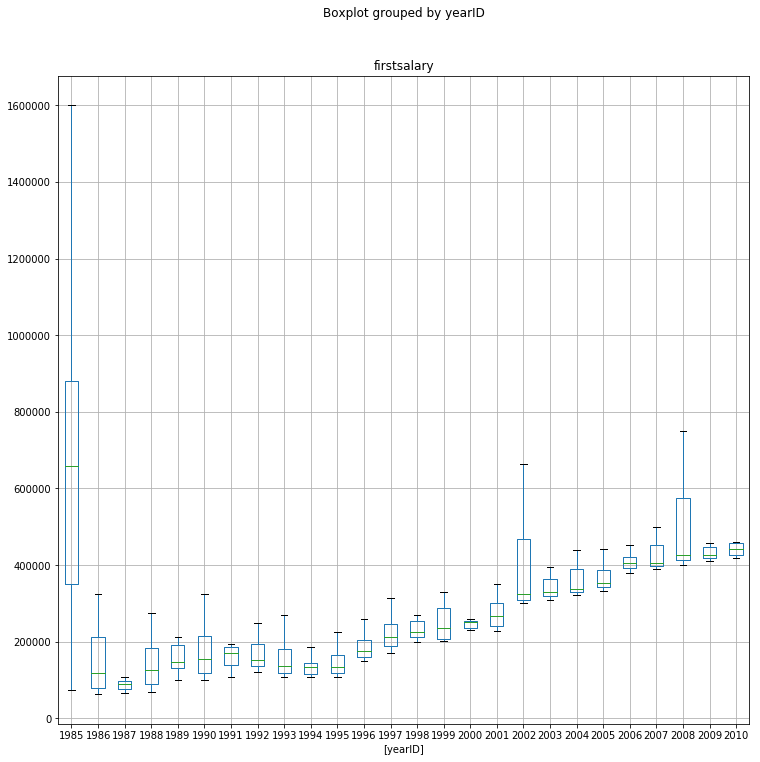

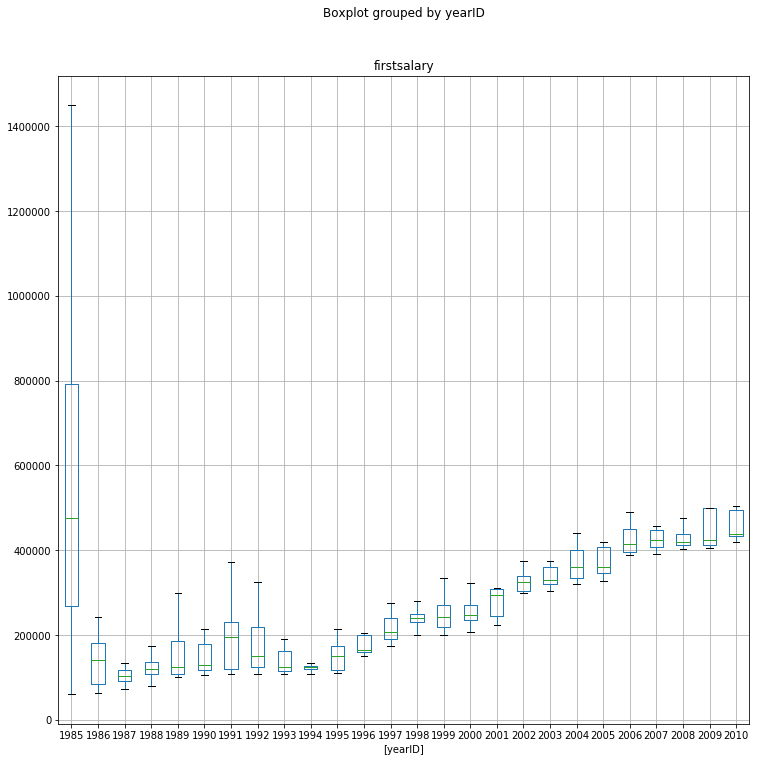

In [205]:
df[(df['firstyear']==df['yearID']) & (df['lgID']=='NL')].boxplot(column=['firstsalary'], by = ['yearID'], showfliers = False, figsize=(12,12))
df[(df['firstyear']==df['yearID']) & (df['lgID']=='AL')].boxplot(column=['firstsalary'], by = ['yearID'], showfliers = False, figsize=(12,12))

In [197]:
df[(df['firstyear']==df['yearID']) & (df['firstyear']==1986) & (df['firstsalary']>200000)]

,id,playerID,yearID,stint,teamID,lgID,W,L,G,GS,...,WP,HBP,BK,BFP,GF,R,salary_next_year,years,firstsalary,firstyear
23,23,morgami01,1986,1,SEA,AL,11,17,37,33,...,8.0,4.0,1.0,951.0,2.0,122,375000.0,0.0,375000.0,1986.0
338,338,smithza01,1986,1,ATL,NL,8,16,38,32,...,8.0,5.0,0.0,889.0,2.0,109,250000.0,0.0,250000.0,1986.0
623,623,aasedo01,1986,1,BAL,AL,6,7,66,0,...,4.0,0.0,0.0,337.0,58.0,29,625000.0,0.0,625000.0,1986.0
696,696,farrst01,1986,1,KCA,AL,8,4,56,0,...,4.0,4.0,1.0,443.0,33.0,39,225000.0,0.0,225000.0,1986.0
1094,1094,masonro01,1986,1,SFN,NL,3,4,11,11,...,1.0,3.0,0.0,262.0,0.0,35,225000.0,0.0,225000.0,1986.0
1253,1253,willica01,1986,1,CIN,NL,1,3,29,0,...,3.0,1.0,1.0,233.0,7.0,29,325000.0,0.0,325000.0,1986.0
1911,1911,harrigr01,1986,1,TEX,AL,10,8,73,0,...,2.0,1.0,1.0,462.0,63.0,40,620000.0,0.0,620000.0,1986.0
2608,2608,willsfr01,1986,1,CLE,AL,4,4,26,0,...,2.0,0.0,0.0,182.0,16.0,23,242500.0,0.0,242500.0,1986.0
2883,2883,walkbo01,1986,1,PIT,NL,7,8,44,15,...,12.0,3.0,1.0,592.0,7.0,66,285000.0,0.0,285000.0,1986.0
2997,2997,howelke01,1986,1,LAN,NL,6,12,62,0,...,4.0,3.0,0.0,437.0,36.0,48,215000.0,0.0,215000.0,1986.0


In [200]:
mask = (df['playerID']=='lawva01').values
df.iloc[mask,:].sort_values(by='yearID')

,id,playerID,yearID,stint,teamID,lgID,W,L,G,GS,...,WP,HBP,BK,BFP,GF,R,salary_next_year,years,firstsalary,firstyear
4070,4070,lawva01,1986,1,MON,NL,0,0,3,0,...,1.0,0.0,0.0,16.0,3.0,2,525000.0,0.0,525000.0,1986.0
3029,3029,lawva01,1987,1,MON,NL,0,0,3,0,...,1.0,0.0,0.0,15.0,3.0,2,500000.0,1.0,525000.0,1986.0
